# Post processing code


This code will be used for post processing the configurations obtained from the simulation it must import the numpy arrays and display the lattice, do energy, specfic heat and magnetisation measurements

# Libraries

In [205]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from numpy import linalg as LA
from numpy.random import normal
import scipy
from scipy.spatial.transform import Rotation as R
from pathlib import Path
import os
import plotly.graph_objects as go

In [206]:
class Configuration:
    #This is the class used to do the simulation
    
    def __init__(self,Nx,Ny, J,oldconfig,lattice):
        #we create a kagome lattice from parameter a and theta with Nx*Ny*3 spins
        # for this we define a few global variables 
        self.a,self.theta,self.Nx,self.Ny,self.J=1,2*np.pi/3,Nx,Ny,J,
        self.N=Nx*Ny*3
        
        # we construct the grid points from the translations of the lattice
        self.x_l,self.y_l=np.meshgrid(range(Nx),range(Ny))


        # the lattice points coordinates are created from adding a unit cell at each grid point
        self.lattice=lattice

        # we create a dim object containing the dimensions of the lattice 
        dim=self.lattice.shape 


        self.config=oldconfig



        

    def get_mean_field(self):
        #This part of the code adds the spins of the neighbors at lattice point
        #this creates a vector which is very usefull get energy contribution 
        # and do overelaxation fast

        # we create the (self.Nx,self.Ny, 3,3) tensor

        self.mean_field=np.zeros(self.config.shape)

        # we add the fields from the two other points on a triangle
        self.mean_field[:,:,0,:]=self.config[:,:,1,:]+self.config[:,:,2,:]
        self.mean_field[:,:,1,:]=self.config[:,:,2,:]+self.config[:,:,0,:]
        self.mean_field[:,:,2,:]=self.config[:,:,0,:]+self.config[:,:,1,:]


        #self.mean_field[:,:,0,:]+= np.roll(self.config[:,:,1,:],(0,-1),axis=(0,1)).copy()+np.roll(self.config[:,:,2,:],(-1,0),axis=(0,1)).copy()
        #self.mean_field[:,:,1,:]+=np.roll(self.config[:,:,2,:],(-1,1),axis=(0,1)).copy()+np.roll(self.config[:,:,0,:],(0,1),axis=(0,1)).copy()
        #self.mean_field[:,:,2,:]+=np.roll(self.config[:,:,0,:],(1,0),axis=(0,1)).copy()+np.roll(self.config[:,:,1,:],(1,-1),axis=(0,1)).copy()

        #then we add the spins of two neighboring points
        self.mean_field[:,:,0,:]+= np.roll(self.config[:,:,1,:],(0,1),axis=(0,1)).copy()+np.roll(self.config[:,:,2,:],(1,0),axis=(0,1)).copy()
        self.mean_field[:,:,1,:]+=np.roll(self.config[:,:,2,:],(1,-1),axis=(0,1)).copy()+np.roll(self.config[:,:,0,:],(0,-1),axis=(0,1)).copy()
        self.mean_field[:,:,2,:]+=np.roll(self.config[:,:,0,:],(-1,0),axis=(0,1)).copy()+np.roll(self.config[:,:,1,:],(-1,1),axis=(0,1)).copy()
        return self.mean_field
  


    def total_energy(self):
        # the total energy is just a dot product of the vector at each lattice site with 
        #the sum of neighbor's spins of course there is an overcounting factor 
        #that will be taken care of in post processing
        M1=self.get_mean_field()
        M2=self.config
        #the np einsum allows us to deal with the 4 dimensional array efficiently
        E=self.J*np.sum(np.einsum('ijkl,ijkl->ijk', M1, M2))

        return E





    def delta_energy(self):
        # this function is used to compute the energy difference for each 
        # lattice point this is very usefull to do the MC step 
        # at the same time on the whole lattice
        M1=self.get_mean_field()

        #we use the difference between the new and old spins
        M2=self.flipped_spin-self.config
        
        #the energy change at each lattice site is calculated with a dot product
        C=np.einsum('ijkl,ijkl->ijk', M1, M2)


        #we do not forget the J factor
        Delta_E=(self.J)*C
    
        return Delta_E


    def overrelaxation_2(self,dose=0.1):
        #In this part we implement Nf iterrations of overrelaxation
      


        # we select the number Nf of sites that will be rotated
        Nf=int(round(dose*self.N))
        pick = np.zeros(self.N)
        pick[:Nf-1]=1
        np.random.shuffle(pick)
        pick=np.reshape(pick,(self.Nx,self.Ny,3))
        pick=pick.astype(bool)
        newpick=np.repeat(pick[:, :,:, np.newaxis], 3, axis=3)



        B=self.get_mean_field()
        Norm=np.repeat(LA.norm(B,axis=3)[:, :,:, np.newaxis], 3, axis=3)
        B/=Norm


        dotproduct=np.einsum('ijkl,ijkl->ijk', B, self.config)
        newdotproduct=np.repeat(dotproduct[:, :,:, np.newaxis], 3, axis=3)
        normal=self.config-newdotproduct*B



        newarr=self.config-2*normal

        self.config=np.where(newpick,newarr,self.config )
        


    def overrelaxation(self,dose=0.1):
        '''In this part we implement Nf iterrations of overrelaxation'''
      

        Nf=int(round(dose*self.N))
        pick=np.concatenate((np.ones(Nf),np.zeros(self.N-Nf)))
        np.random.shuffle(pick)
        pick=np.reshape(pick,(self.Nx,self.Ny,3))
        pick=pick.astype(bool)
        newpick=np.repeat(pick[:, :,:, np.newaxis], 3, axis=3)    


        B=self.get_mean_field()

        angle=np.pi
        Rot=np.zeros((self.Nx,self.Ny,3,4))
        Rot[:,:,:,0]=np.cos(angle/2)
        Rot[:,:,:,1:]=np.sin(angle/2)*B
        Norm=np.repeat(LA.norm(Rot,axis=3)[:, :,:, np.newaxis], 4, axis=3)
        Rot/=Norm
        Rotad=np.reshape(Rot,(self.N,4),order='C').copy()
        r = R.from_quat(Rotad,scalar_first=True)
        newarr=r.apply(  np.reshape(self.config,(self.N,3),order='C').copy())



        self.config=np.where(newpick,np.reshape(newarr,(self.Nx,self.Ny,3,3),order='C') ,self.config )




    def Monte_Carlo(self,Nf,T,measure_capa=False,overrelaxation=False,overrelaxation_dose=0.1):
        #'''In this part we implement the Nf monte carlo steps
        #here with the metropolis move'''

        Ener=[]
        beta=1/T

        for comp in range(Nf):

            

                    
            n = np.random.normal(0,(3*T,3*T,T),(self.Nx,self.Ny,3,3))
            self.flipped_spin=self.config+n
            Norm=np.repeat(LA.norm(self.flipped_spin,axis=3)[:, :,:, np.newaxis], 3, axis=3)
            self.flipped_spin/=Norm
            

            delta=self.delta_energy()


            proba=np.random.rand(self.Nx,self.Ny,3)
            expener=np.exp(-beta*delta)
            decision=np.where(proba< expener)


            newproba = np.repeat(proba[:, :,:, np.newaxis], 3, axis=3)
            newexpener= np.repeat(expener[:, :,:, np.newaxis], 3, axis=3)
            self.config=np.where(newproba<= newexpener,self.flipped_spin,self.config)


            flag=len(decision[0])

            if overrelaxation==True:

                self.overrelaxation_2(overrelaxation_dose)


            if comp%100==0 and measure_capa==True:
                Ener.append(self.total_energy())
                #print(self.total_energy())
                self.acceptation_rates.append(flag/self.N)
                #print(flag/self.N,T)
                
                
        if measure_capa==True:
            Capacite=np.var(Ener)/(T**2)
            self.Capa.append(Capacite)
            self.Energy=np.concatenate((self.Energy,Ener))
            self.Temperatures.append(T*np.ones(len(Ener)))


    
    def display_config(self):
        """Interactive 3D visualization using Plotly"""
        position = np.reshape(self.lattice, (3 * self.Nx * self.Ny, 2), order='C')
        arrows = np.reshape(self.config, (3 * self.Nx * self.Ny, 3), order='C')

        x, y, z = position[:, 0], position[:, 1], np.zeros(3 * self.Nx * self.Ny)
        Sx, Sy, Sz = arrows[:, 0], arrows[:, 1], arrows[:, 2]

        X_lines, Y_lines, Z_lines = [], [], []
        for xi, yi, zi, Sxi, Syi, Szi in zip(x, y, z, Sx, Sy, Sz):
            X_lines += [xi, xi + Sxi, None]
            Y_lines += [yi, yi + Syi, None]
            Z_lines += [zi, zi + Szi, None]

        fig = go.Figure()
        fig.add_trace(go.Scatter3d(x=X_lines, y=Y_lines, z=Z_lines,
                                   mode="lines", line=dict(width=3, color="blue"), name="Spins"))
        fig.add_trace(go.Scatter3d(x=x, y=y, z=z,
                                   mode="markers", marker=dict(size=4, color="red"), name="Lattice points"))

        fig.update_layout(
            title="Kagome Lattice Spin Configuration",
            scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z", aspectmode='data'),
            width=1200, height=800
        )
        fig.show(renderer="browser")

    def spin_realign(self):



        position=np.reshape(self.lattice,(3*self.Nx*self.Ny,2),order='C')
        arrows=np.reshape(self.config,(3*self.Nx*self.Ny,3),order='C')

        Avg=[]
        for i in range(self.Nx):
            for j in range(self.Ny):
                n=np.cross(self.config[i,j,0,:],self.config[i,j,1,:])
                n2=np.cross(self.config[i,j,2,:],n)
                Avg.append(n)

        Avgn=np.mean(Avg,axis=0)
        #Avgn=np.mean(arrows,axis=0)


        def f(q,Avg=Avgn):

            q/=np.linalg.norm(q)
            r=R.from_quat(q)
            newavg = r.apply(Avg)
            return (1-newavg[2])**2

        res=scipy.optimize.minimize(f,np.array([1,1,1,1]), method='nelder-mead')
        r=R.from_quat(res.x)
        arrows=r.apply(arrows,inverse=False)

        
        x, y, z = position[:, 0], position[:, 1], np.zeros(3 * self.Nx * self.Ny)
        Sx, Sy, Sz = arrows[:, 0], arrows[:, 1], arrows[:, 2]

        X_lines, Y_lines, Z_lines = [], [], []
        for xi, yi, zi, Sxi, Syi, Szi in zip(x, y, z, Sx, Sy, Sz):
            X_lines += [xi, xi + Sxi, None]
            Y_lines += [yi, yi + Syi, None]
            Z_lines += [zi, zi + Szi, None]

        fig = go.Figure()
        fig.add_trace(go.Scatter3d(x=X_lines, y=Y_lines, z=Z_lines,
                                   mode="lines", line=dict(width=3, color="blue"), name="Spins"))
        fig.add_trace(go.Scatter3d(x=x, y=y, z=z,
                                   mode="markers", marker=dict(size=4, color="red"), name="Lattice points"))

        fig.update_layout(
            title="Kagome Lattice Spin Configuration",
            scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z", aspectmode='data'),
            width=1200, height=800
        )
        fig.show(renderer="browser")



    def verify_norm(self):
        """ we have sometimes a problem with the  spin vectors not 
        being normalised after too many rotations due to errors so we normalise them after each 
        flip and we verify their maximum norms"""
        print('maximumspinsnorm=',LA.norm(self.config,axis=3).max())
        print('maximumrotatedvectornorm=',LA.norm(self.flipped_spin,axis=3).max())





40
40


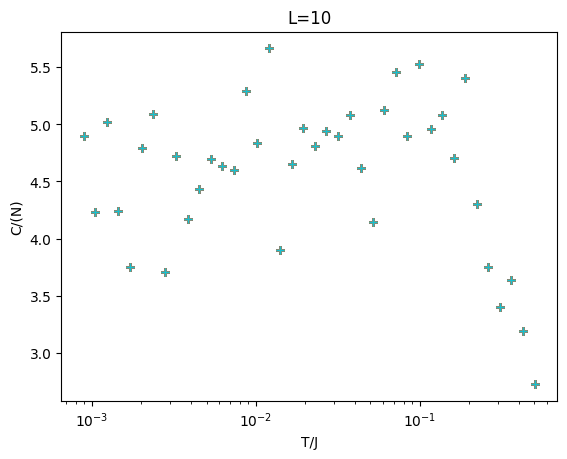

In [209]:
cwd = Path.cwd()
parent = cwd.parent

directory='AAA'
relative_path = 'Results/'+str(directory)

full_path = os.path.join(parent, relative_path)


from itertools import chain


p = Path(full_path)
#for file in (chain(p.glob('**/*.npy'))):
   # print(file)
#lena=1
C=[]
Temp=[]
i=0
for file in sorted(chain(p.glob('**/*.npy'))):
    #print(file)
    i+=1
    #print(file)

#file ='/home/thau/Documents/Github/.venv/Numerical-Physics-Project-order-by-disorder-/Numerical-Physics-Project-order-by-disorder-/Results/CCCORDER6/simulation39.npy'
#infos=np.load(file,allow_pickle=True).item()
Nx=infos['Nx']
Ny=infos['Ny']
A=Configuration(Nx,Ny, J,infos['configuration'],infos['lattice'])
A.spin_realign()


N=3*Nx*Ny
J=infos['J']
T=infos['Temperatures']
print(len(T))
C=infos['Capacité']
print(len(C))

cutoff=500
#x1 = T[0:cutoff:2]
error=[]

#y1 = np.array(C[4:cutoff:5])*(1/(10*Nx*Ny*3))
x1=T
y1=np.array(C)/N
#plt.ylim(0,1.5)
plt.semilogx(x1,y1,'+')
plt.xlabel('T/J')
plt.title('L=10')
plt.ylabel('C/(N)')
plt.show()

In [208]:
def order_param(,lattice,config,N):

    sisj1=np.sum(np.einsum('...l,...l->'config,config))
    sisj2=np.sum(np.power(np.einsum('...l,...l->'config,config),2))
    sisj3=np.sum(np.power(np.einsum('...l,...l->'config,config),3))

    Q2=(1/(N**2))*sisj2-1/3
    T2=(1/(N**2))*(sisj3-(3/5)*sisj)



SyntaxError: invalid syntax (1610245508.py, line 1)

# files are not read in the good order tha's why

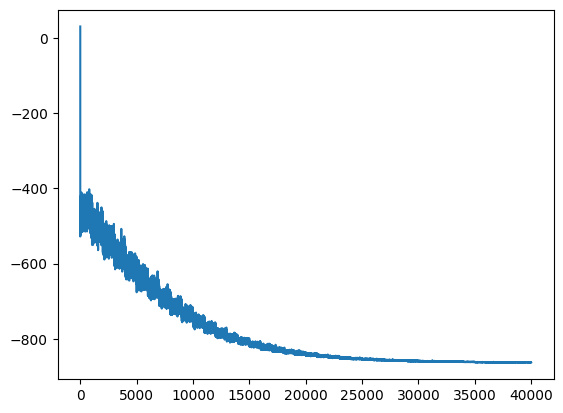

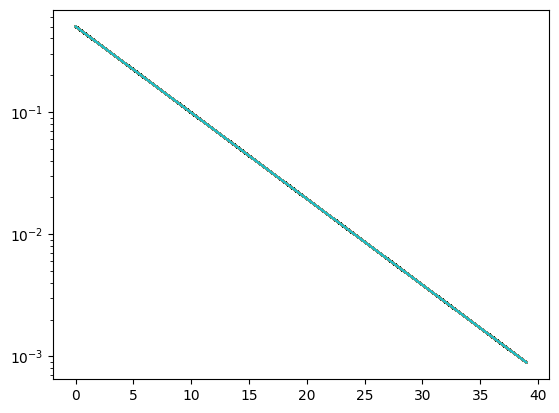

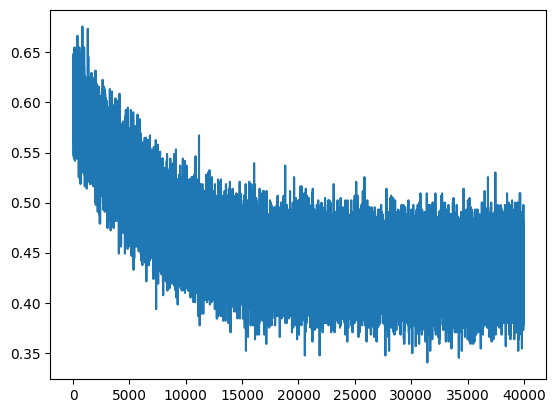

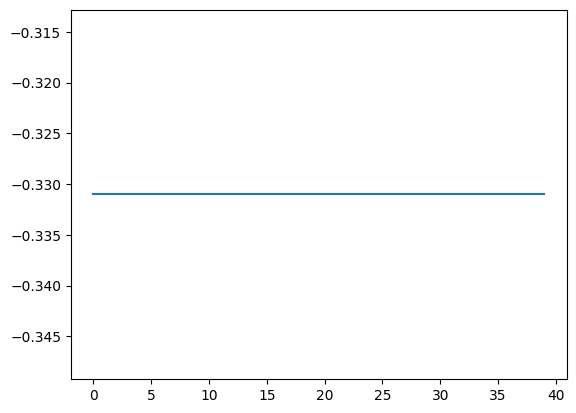

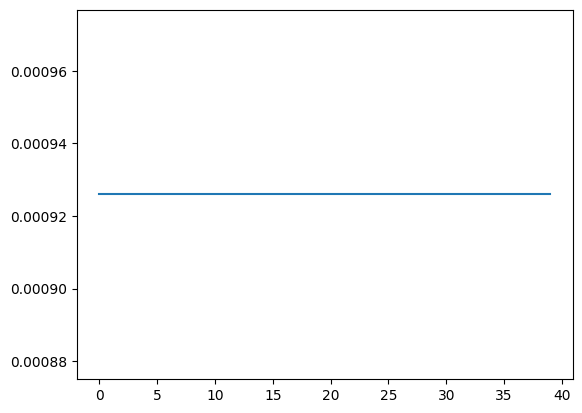

ValueError: x and y must have same first dimension, but have shapes (495,) and (35,)

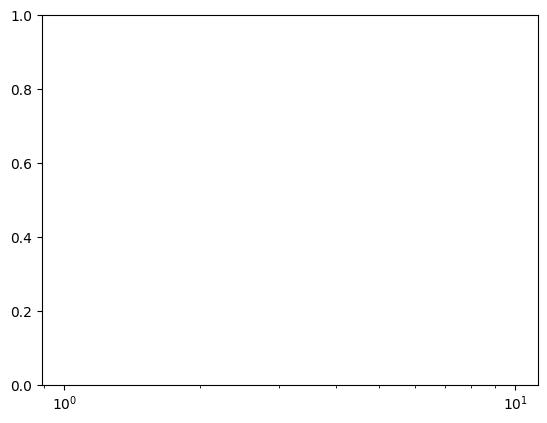

In [ ]:
cwd = Path.cwd()
parent = cwd.parent

directory='AAA24'
relative_path = 'Results/'+str(directory)

full_path = os.path.join(parent, relative_path)


from itertools import chain


p = Path(full_path)
#for file in (chain(p.glob('**/*.npy'))):
   # print(file)
#lena=1
C=[]
Temp=[]
for file in sorted(chain(p.glob('**/*.npy'))):
    infos=np.load(file,allow_pickle=True).item()
    #print(file)
    #print(infos.keys())
    #infos=np.load(f"/home/thau/Documents/Github/.venv/Numerical-Physics-Project-order-by-disorder-/Numerical-Physics-Project-order-by-disorder-/Results/testnewoverLS3{i}.npy",allow_pickle=True).item()
    Nx=infos['Nx']
    Ny=infos['Ny']
    J=infos['J']
    #A=Configuration(1,theta,Nx,Ny,J,infos['configuration'])
    T=infos['Temperature']
    #print(len(infos['Energy']))
    
    #sliceE=infos['Energy'][lena:]
    #lena=len(infos['Energy'])
    #Capa=((np.mean(sliceE**2)-np.mean(sliceE)**2)/(T**2))
    #EI.append(E)
   # C.append(infos['Capacité'][2])
    #print(infos['Capacité'][2])
    Temp.append(infos['Temperature'])





file='/home/thau/Documents/Github/.venv/Numerical-Physics-Project-order-by-disorder-/Numerical-Physics-Project-order-by-disorder-/Results/CCCORDER12/simulation39.npy'
infos=np.load(file,allow_pickle=True).item()
Nx=infos['Nx']
Ny=infos['Ny']
J=infos['J']


A=Configuration(Nx,Ny, J,infos['configuration'],infos['lattice'])
A.display_config()

A.spin_realign()
x = range(len(infos['Energy']))
y = infos['Energy']

plt.plot(x,y)  # Log x-axis only
plt.show()
#print(infos['configuration'])


x = range(len(infos['Temperatures']))
y = infos['Temperatures']

plt.semilogy(x,y)  # Log x-axis only
plt.show()
#print(infos['configuration'])

x = range(len(infos['acceptation_rate']))
y = infos['acceptation_rate']

plt.plot(x,y)  # Log x-axis only
plt.show()



x = range(len(infos['Q2']))
y = infos['Q2']

plt.plot(x,y)  # Log x-axis only
plt.show()

x = range(len(infos['T2']))
y = infos['T2']

plt.plot(x,y)  # Log x-axis only
plt.show()


C=infos['Capacité']

#A.spin_realign()

x = np.repeat(Temp,5)
y = C[:len(C)-5]

plt.semilogx(x, y,'+')  # Log x-axis only
plt.show()


# Todolist
- benchmark differents L and MC steps
-explainations of different design choices for perf
- planify simulations
- order parameters and animation